# Machine Vision 2022/23 - Assignment 7: Deep Learning

In this exercises you will apply different concepts of deep learning in order to classify images of traffic signs. While working through this notebook, different links to official web-sites or blog-posts are provided for additional information.
This exercise uses the Tensorflow framework, which is one of the most popular deep learning frameworks.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

2023-02-10 09:01:56.514703: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


##### Preparation

##### German Traffic Sign Recognition Benchmark

The German Traffic Sign Recognition Benchmark [(GTSRB)](https://benchmark.ini.rub.de/) is a competition that was held at the IJCNN 2011. In this competition images of traffic signs should be classified.
You will implement your own neural network to classify a subset of the GTSRB dataset. This subset consists of `12` different classes, which are shown in the figures below. However, you are free to extend your solution to the full dataset.


|---|------------------------------|-------------------------------|-------------------------------|-------------------------------|-------------------------------|-------------------------------|-------------------------------|-------------------------------|-------------------------------|--------------------------------|--------------------------------|--------------------------------|
|  ![Class 0](res/images/0.png) | ![Class 1](res/images/6.png) | ![Class 2](res/images/16.png) | ![Class 3](res/images/17.jpg) | ![Class 4](res/images/19.png) | ![Class 5](res/images/22.jpg) | ![Class 6](res/images/28.png) | ![Class 7](res/images/29.png) | ![Class 8](res/images/32.png) | ![Class 9](res/images/33.png) | ![Class 10](res/images/38.png) | ![Class 11](res/images/40.png) |
<br></br>

In order to simplify this exercise, the raw GTSRB images are already transformed into a dataset, where each image has the shape of `[H,W,C]` (Height x Width x Channels) with values ranging from `0-1`.
Furthermore, the dataset is split into a train-, validation- and test-dataset, where the train- and validation-datasets are provided.

In [2]:
NUM_CLASSES = 12

def get_datasets(*, images, labels, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((np.load(images), np.load(labels)))

    if shuffle:
        ds = ds.shuffle(1024)

    return ds.batch(32)

# Create a dataset for training
train_ds = get_datasets(
    images="res/images_train.npy",
    labels="res/labels_train.npy",
)
# Create a dataset for validation
val_ds = get_datasets(
    images="res/images_val.npy",
    labels="res/labels_val.npy",
    shuffle=False
)

2023-02-10 09:01:58.027242: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-10 09:01:58.035386: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2023-02-10 09:01:58.036541: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-02-10 09:01:58.037134: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library

The `gen_datasets` function creates a [Tensorflow dataset](https://blog.tensorflow.org/2019/02/introducing-tensorflow-datasets.html) from two numpy arrays containing the images and the corresponding ground truth class labels.

A Tensorflow dataset is a python class, which provide an easy way iterate a dataset. Each iteration, the dataset returns a batch of `x = [Bx32x32x3]` images and `y = [Bx12]` class labels, where B is the batch size.

There are different approaches to encode the class label. For further information you can read this blog entry [integer- or one-hot-encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/).
In this exercise the labels are encoded in one-hot format. Which means, that each label is a vector of 12 entries, where only the entry of the class has the value $1$ and all others values are $0$.

In [3]:
x_batch, y_batch = next(iter(train_ds))

# @student print the image and label shape of a batch
print(f"image shape: {x_batch.shape}")
print(f"label shape: {y_batch.shape}")

image shape: (32, 32, 32, 3)
label shape: (32, 12)


label: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


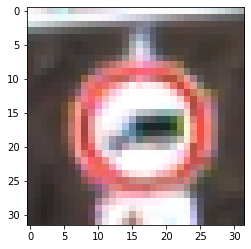

In [4]:
# @student show one image of the batch and its label
print(f"label: {y_batch[1]}")
plt.imshow(x_batch[1])
plt.show()

##### Execution

In order to compare models against each other metrics are calculated on an unseen test dataset. In this exercise you should try to develop your own model and upload the `final_model` directory to ilias.
All submitted models are compared to each other using the accuracy metric.

**The student that submits the best model will be given the chance to be in the passenger seat while our autonomous car drives around the adenauer ring**.

In [5]:
def create_model(image_shape):
    input = tf.keras.layers.Input(shape=image_shape)
    # @student implement your neural network

    # Augementation Layers
    x = tf.keras.layers.RandomBrightness(factor=(-0.5, 0.5), value_range=(0, 1))(input)

    # Model Layers
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.AveragePooling2D()(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.AveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units=120, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(units=84, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(units=NUM_CLASSES, activation="linear")(x)

    return tf.keras.Model(inputs=input, outputs=x)

In the `create_model` function you can define your own neural network using the [functional tensorflow API](https://www.tensorflow.org/guide/keras/functional).
You can also use other tensorflow APIs like the [SequentialModel](https://www.tensorflow.org/guide/keras/sequential_model). However, when transitioning to complex architectures the functional API provides the more flexibility.


You are free to use any layer and activation provided by tensorflow for example:
[tf.keras.layers.Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
[tf.keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)
[tf.keras.layers.AveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D)
[tf.keras.layers.Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)
[tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)
[tf.keras.activations.relu](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu)

For inspiration you can take a look at these ground-breaking publications:
[LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)
[AlexNet](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
[GoogLeNet](https://arxiv.org/pdf/1409.4842.pdf)
[ResNet](https://arxiv.org/pdf/1512.03385.pdf)

Additionally, you can also add data augmentation to the training data in order to improve the generalization of your model.

In [6]:
model = create_model(image_shape=(32,32,3))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 random_brightness (RandomBr  (None, 32, 32, 3)        0         
 ightness)                                                       
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 average_pooling2d (AverageP  (None, 15, 15, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496 

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-3)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
acc_metric = tf.keras.metrics.CategoricalAccuracy(name="accuracy")
model.compile(optimizer, loss=loss_fn, metrics=[acc_metric])
model.fit(
    train_ds,
    epochs=25,
    validation_data=val_ds,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(filepath="final_model", monitor='val_accuracy', mode='max', save_best_only=True)
    ]
)

Epoch 1/25
217/217 [==============================] - ETA: 0s - loss: 1.4010 - accuracy: 0.5462

217/217 [==============================] - 5s 20ms/step - loss: 1.4010 - accuracy: 0.5462 - val_loss: 2.5948 - val_accuracy: 0.2333
Epoch 2/25
216/217 [============================>.] - ETA: 0s - loss: 0.8625 - accuracy: 0.7258

217/217 [==============================] - 9s 41ms/step - loss: 0.8613 - accuracy: 0.7260 - val_loss: 1.4670 - val_accuracy: 0.5750
Epoch 3/25
216/217 [============================>.] - ETA: 0s - loss: 0.5030 - accuracy: 0.8410

217/217 [==============================] - 8s 37ms/step - loss: 0.5032 - accuracy: 0.8411 - val_loss: 1.1006 - val_accuracy: 0.6000
Epoch 4/25
216/217 [============================>.] - ETA: 0s - loss: 0.4365 - accuracy: 0.8562

217/217 [==============================] - 7s 34ms/step - loss: 0.4365 - accuracy: 0.8562 - val_loss: 1.6335 - val_accuracy: 0.6250
Epoch 5/25
215/217 [============================>.] - ETA: 0s - loss: 0.4185 - accuracy: 0.8657

217/217 [==============================] - 7s 34ms/step - loss: 0.4166 - accuracy: 0.8663 - val_loss: 0.8032 - val_accuracy: 0.7500
Epoch 6/25
217/217 [==============================] - ETA: 0s - loss: 0.3499 - accuracy: 0.8860

217/217 [==============================] - 8s 36ms/step - loss: 0.3499 - accuracy: 0.8860 - val_loss: 0.8461 - val_accuracy: 0.7667
Epoch 7/25
217/217 [==============================] - ETA: 0s - loss: 0.2753 - accuracy: 0.9095

217/217 [==============================] - 8s 35ms/step - loss: 0.2753 - accuracy: 0.9095 - val_loss: 0.6758 - val_accuracy: 0.8500
Epoch 8/25
217/217 [==============================] - 5s 25ms/step - loss: 0.2473 - accuracy: 0.9187 - val_loss: 0.6786 - val_accuracy: 0.8167
Epoch 9/25
215/217 [============================>.] - ETA: 0s - loss: 0.2251 - accuracy: 0.9289

217/217 [==============================] - 8s 35ms/step - loss: 0.2249 - accuracy: 0.9288 - val_loss: 0.5001 - val_accuracy: 0.9000
Epoch 10/25
217/217 [==============================] - 5s 24ms/step - loss: 0.2082 - accuracy: 0.9346 - val_loss: 0.4496 - val_accuracy: 0.8583
Epoch 11/25
217/217 [==============================] - 6s 27ms/step - loss: 0.1937 - accuracy: 0.9398 - val_loss: 0.8537 - val_accuracy: 0.8500
Epoch 12/25
217/217 [==============================] - 6s 26ms/step - loss: 0.2146 - accuracy: 0.9342 - val_loss: 0.4428 - val_accuracy: 0.8667
Epoch 13/25
217/217 [==============================] - 6s 26ms/step - loss: 0.2011 - accuracy: 0.9363 - val_loss: 1.0292 - val_accuracy: 0.8083
Epoch 14/25
217/217 [==============================] - ETA: 0s - loss: 0.1887 - accuracy: 0.9410

217/217 [==============================] - 8s 35ms/step - loss: 0.1887 - accuracy: 0.9410 - val_loss: 0.2278 - val_accuracy: 0.9417
Epoch 15/25
217/217 [==============================] - 5s 24ms/step - loss: 0.1689 - accuracy: 0.9460 - val_loss: 0.4905 - val_accuracy: 0.8750
Epoch 16/25
217/217 [==============================] - 6s 28ms/step - loss: 0.1632 - accuracy: 0.9488 - val_loss: 0.2932 - val_accuracy: 0.9333
Epoch 17/25
217/217 [==============================] - 6s 25ms/step - loss: 0.1590 - accuracy: 0.9503 - val_loss: 0.5758 - val_accuracy: 0.9083
Epoch 18/25
217/217 [==============================] - 5s 25ms/step - loss: 0.1557 - accuracy: 0.9512 - val_loss: 0.1910 - val_accuracy: 0.9417
Epoch 19/25
217/217 [==============================] - 5s 25ms/step - loss: 0.1520 - accuracy: 0.9524 - val_loss: 0.4585 - val_accuracy: 0.9083
Epoch 20/25
217/217 [==============================] - 5s 25ms/step - loss: 0.1739 - accuracy: 0.9440 - val_loss: 0.4996 - val_accuracy: 0.9167
Epoc

In [8]:
model = tf.keras.models.load_model("final_model/")
loss, acc = model.evaluate(val_ds)

4/4 [==============================] - 0s 4ms/step - loss: 0.2278 - accuracy: 0.9417


#### From Logits to Labels

Your network will output logits as long as you use `tf.keras.losses.CategoricalCrossentropy` as loss function.
However, if you want to manually infer you have to calculate the predicted label based on the logits.

4/4 [==============================] - 0s 4ms/step


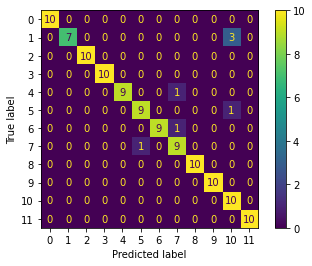

In [9]:
pred_logit = model.predict(val_ds)
y_labels = [labels for _, labels in val_ds.unbatch()]
y_labels = tf.argmax(y_labels, axis=1)


# @student: pred_logit are the predicted logits of your model, while y_labels are the ground truth labels.
# calculate the labels from the logits
pred_softmax = tf.math.softmax(pred_logit)
pred_labels = tf.argmax(pred_softmax, -1)


confusion_matrix = tf.math.confusion_matrix(y_labels, pred_labels, num_classes=NUM_CLASSES)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix.numpy())
disp.plot()
plt.show()